# MCMC

Brief notebook that demonstrates the MCMC generic functions (not cryo-EM specific) implemented in this repository. 

In [1]:
from jax.config import config
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import random

from simplecryoem.sampling import mcmc_sampling, proposal_hmc

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

### Generate samples from a multivariate normal distribution

(-12.0, 12.0)

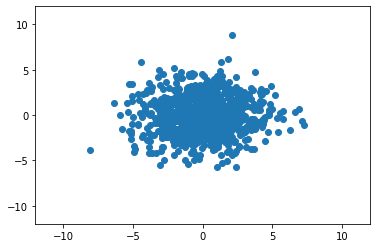

In [3]:
key = random.PRNGKey(10)

N_samples = 1000
k = 10
M = jnp.zeros(k)
# c = jnp.array([[1,0],[0,10]])
# c_inv = jnp.array([[1, 0], [0,1/10]])

key, *sk = random.split(key, 4)
V = random.normal(sk[0], [k, k])
Q, _ = jnp.linalg.qr(V)
d = jnp.diag(random.uniform(sk[1], (k,)) * 10)
D = d.at[d < 0].set(0)
C = Q.transpose() @ D @ Q
C_inv = Q.transpose() @ jnp.diag(1 / jnp.diag(D)) @ Q

S = random.multivariate_normal(sk[2], M, C, (N_samples,))
plt.scatter(S[:, 0], S[:, 1])
plt.xlim(-12, 12)
plt.ylim(-12, 12)

In [4]:
# Plot the samples as well as the sample acceptance rate


def plot_mcmc_samples(samples, r, x0, M, C):
    plt.rcParams["figure.figsize"] = 16, 8

    plt.subplot(1, 2, 1)
    plt.plot(x0[0], x0[1], "ro")
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)

    plt.subplot(1, 2, 2)
    plt.plot(r)

    plt.rcParams["figure.figsize"] = 8, 8

    M_est = jnp.mean(samples, axis=0)
    print("Mean error =", jnp.linalg.norm(M - M_est))

    C_est = jnp.cov(samples.transpose())
    print("Covariance error =", jnp.linalg.norm(C - C_est) / jnp.linalg.norm(C))

### Define the functions required by the sampler: $\log(\Pi(x))$ and $\nabla\log(\Pi(x))$

where $\Pi(x)$ is the target distribution.

In [5]:
logPi = lambda x: -1 / 2 * (x - M) @ C_inv @ (x - M) - jnp.log(
    jnp.sqrt((2 * jnp.pi) ** k * jnp.linalg.det(C))
)
gradLogPi = jax.grad(logPi)

pi = lambda x: jnp.exp(logPi(x))
logPi = jax.jit(logPi)
gradLogPi = jax.jit(gradLogPi)

In [6]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
N_samples = 1000
x0 = jnp.array(np.random.randn(k))

### Hamiltonian Monte Carlo

In [7]:
@jax.jit
def proposal_hmc_jit(key, x0, logPiX0, dt_list):
    return proposal_hmc(key, x0, logPiX0, logPi, gradLogPi, dt_list, L=100)

In [8]:
logPiX0 = jnp.inf
print(logPi(x0))
dt_list = jnp.array([0.1])
x1, r, logPiX1, logPiX0 = proposal_hmc_jit(key, x0, logPiX0, dt_list)

print(logPiX0)
logPiX1

-16.472779644891162
-16.472779644891162


DeviceArray(-18.76065131, dtype=float64)

In [9]:
proposal_params_hmc = {"dt_list": jnp.array([0.001, 0.01, 0.1, 1, 10])}

x_mean_hmc, r_hmc, samples_hmc = mcmc_sampling(
    key, proposal_hmc_jit, x0, N_samples, proposal_params_hmc, save_samples=1
)

  MCMC sample 50, posterior val = -19.65295770244299, a = 0.0
  MCMC sample 100, posterior val = -19.10742223799882, a = 1.0
  MCMC sample 150, posterior val = -21.595428166095452, a = 1.0
  MCMC sample 200, posterior val = -21.108137379012888, a = 0.9978656970699594
  MCMC sample 250, posterior val = -23.6332123664244, a = 0.9999999863083106
  MCMC sample 300, posterior val = -21.869169329151767, a = 0.0
  MCMC sample 350, posterior val = -19.19831315052989, a = 0.9999986261591318
  MCMC sample 400, posterior val = -20.25248820789487, a = 0.0
  MCMC sample 450, posterior val = -18.108874535161466, a = 0.9991968498993029
  MCMC sample 500, posterior val = -20.142103803325966, a = 1.0
  MCMC sample 550, posterior val = -18.74055834404801, a = 1.0
  MCMC sample 600, posterior val = -20.003833946897558, a = 0.0
  MCMC sample 650, posterior val = -20.75727860928135, a = 0.0
  MCMC sample 700, posterior val = -21.421528534519336, a = 1.0
  MCMC sample 750, posterior val = -17.63263810007958

Mean error = 0.6238432408839117
Covariance error = 0.18153958572581552


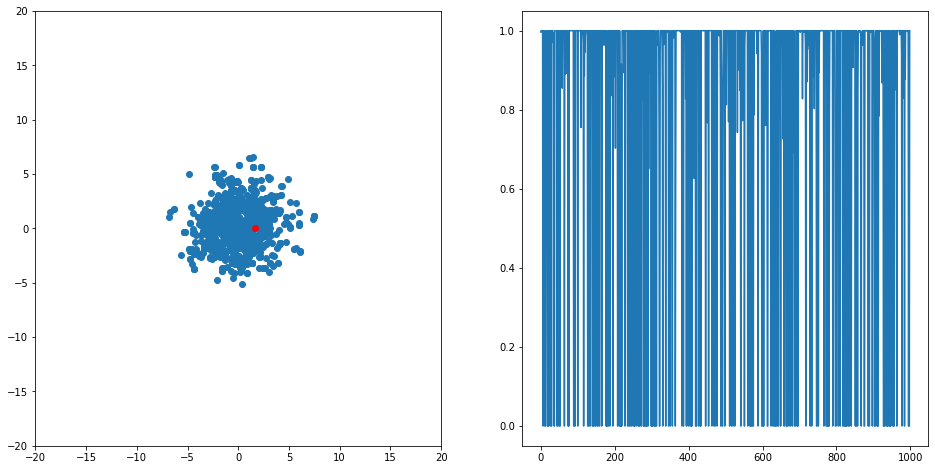

In [10]:
plot_mcmc_samples(samples_hmc, r_hmc, x0, M, C)

In [11]:
# Function to compute the error between the sample mean and covariance
# and the true mean and covariance matrix.


def get_norm_conv(samples, M, C):
    norm_m = []
    norm_c = []
    for i in range(10, N_samples):
        if jnp.mod(i, 50) == 0:
            Merr = jnp.linalg.norm(jnp.mean(samples[:i], axis=0) - M)
            Cerr = jnp.linalg.norm(
                jnp.cov(samples[:i].transpose()) - C
            ) / jnp.linalg.norm(C)
            norm_m.append(Merr)
            norm_c.append(Cerr)

    norm_m = jnp.array(norm_m)
    norm_c = jnp.array(norm_c)
    return norm_m, norm_c

In [12]:
samples_hmc.shape

(999, 10)

In [13]:
# Compute some errors
norm_m_hmc, norm_c_hmc = get_norm_conv(samples_hmc, M, C)
norm_m_an, norm_c_an = get_norm_conv(S, M, C)

In [14]:
xx = []
for i in range(50, N_samples):
    if jnp.mod(i, 50) == 0:
        xx.append(i)
xx = jnp.array(xx)
yy = 1 / jnp.sqrt(xx)

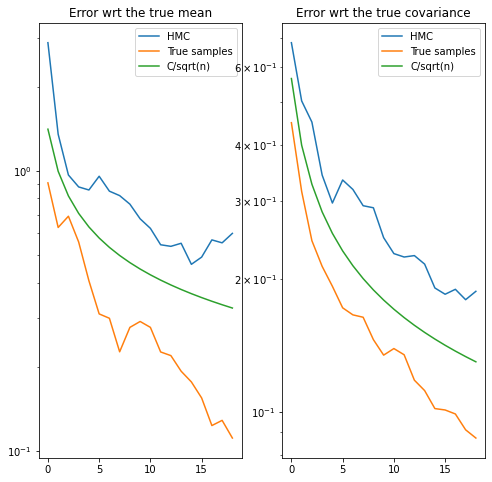

In [15]:
plt.subplot(121)
plt.semilogy(norm_m_hmc)
plt.semilogy(norm_m_an)
plt.semilogy(yy * 10)
plt.title("Error wrt the true mean")
plt.legend(["HMC", "True samples", "C/sqrt(n)"])

plt.subplot(122)
plt.semilogy(norm_c_hmc)
plt.semilogy(norm_c_an)
plt.semilogy(yy * 4)
plt.title("Error wrt the true covariance")
plt.legend(["HMC", "True samples", "C/sqrt(n)"])